# October 6th, 2021

**Motivation**: ROI definition, getting masks, finding voxel sizes in individual spaces <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

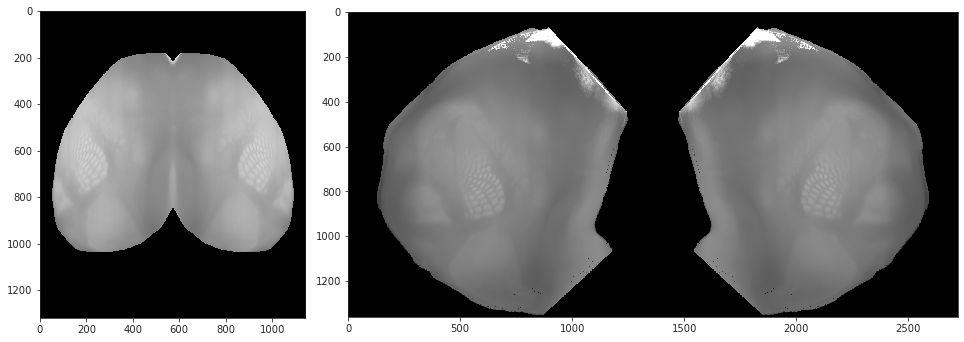

In [2]:
al10 = Allen(10, full_load=False)
template = al10.mcc.get_template_volume()[0]

top = al10.cortical_map(template, proj='top_view', agg_func=np.max)
flatmap = al10.cortical_map(template, proj='dorsal_flatmap', agg_func=np.max)

fig, axes = create_figure(1, 2, (13.5, 7), gridspec_kw={'width_ratios': [1, 2.3]})
axes[0].imshow(top, cmap='Greys_r')
axes[1].imshow(flatmap, cmap='Greys_r')
plt.show()

In [65]:
cfg = Config(512, 4, 100)
mice = Mice(cfg, load_preproc=True, load_parcel=True, load_allen=True)

[PROGRESS] fit columnar: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

[PROGRESS] save 2D 10um: done

[PROGRESS] 2d --> 3d: done

[PROGRESS] fill gaps: done

[PROGRESS] save 3D 10um: done

[PROGRESS] downsample: done

Warning! missing regions:
'[1596, 1597, 3629, 3644, 3645, 3656, 4079]'

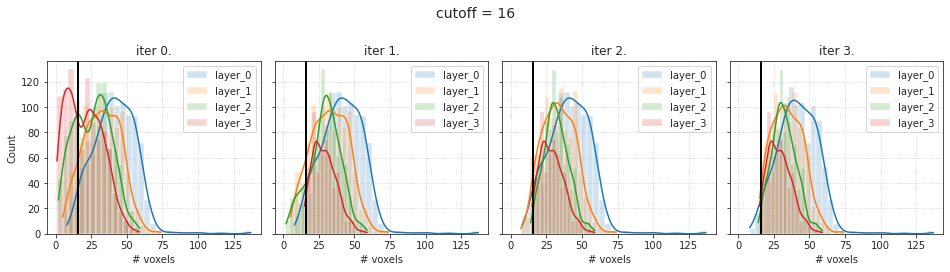

[PROGRESS] merge: done

Warning, region '305' is flat

Warning, region '389' is flat

Warning, region '391' is flat

Warning, region '410' is flat

[PROGRESS] erode: done

num merged regions,     left: 1740,  right: 1740
region id diff,         r - l:  Counter({2048: 1740})

[PROGRESS] fit columnar: done

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*4

[PROGRESS] save results: done.

In [66]:
kwargs = {'cutoff': 2}
mice.parcel.fit_parcel(force_fit=True, **kwargs)

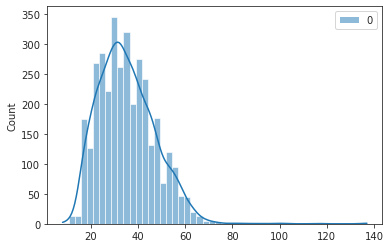

In [69]:
cortex = mice.parcel.results['cortex-merged']
regions = mice.parcel.results['merged-regions']

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

sns.histplot(sizes.values(), bins=50, kde=True)
plt.show()

In [70]:
len(sizes)

3480

In [71]:
list(mice.parcel.results)

[
    'cortex',
    'cortex-eroded',
    'cortex-merged',
    'subcortex',
    'major_masks',
    'cortex-regions',
    'merged-regions',
    'merged-ids',
    'n_cortical_regions',
    'radius',
    'major_colors',
    'cmap'
]

In [72]:
from register.register import *
reg = Register(mice)

In [73]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [18:00<00:00, 36.02s/it]


In [79]:
cortex = mice.parcel.results['cortex-merged']
regions = mice.parcel.results['merged-regions']

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

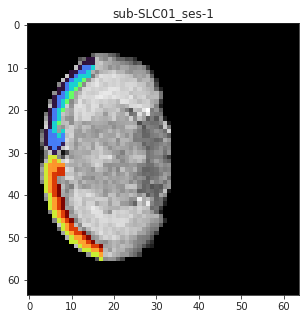

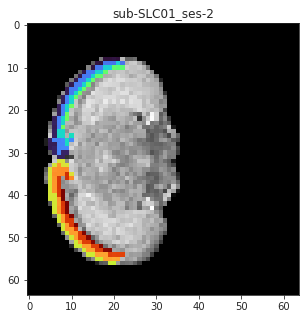

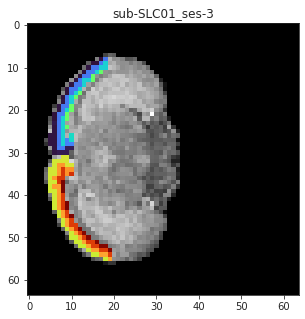

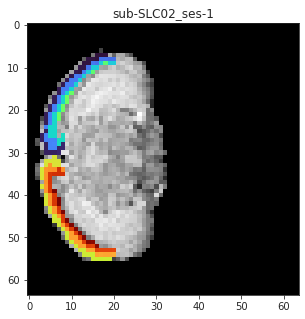

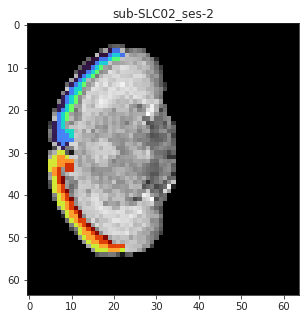

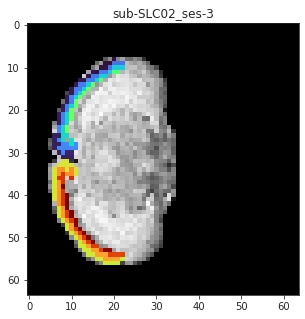

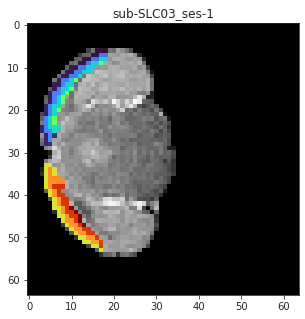

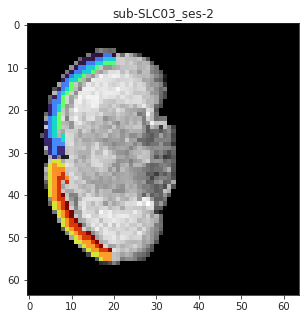

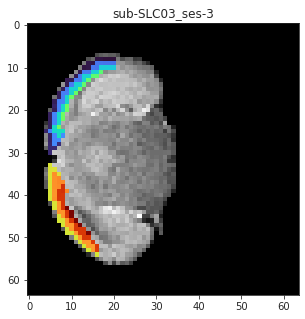

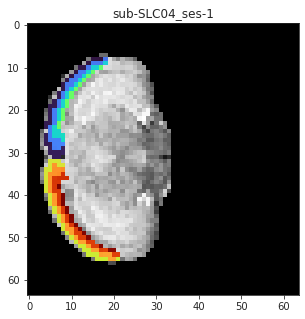

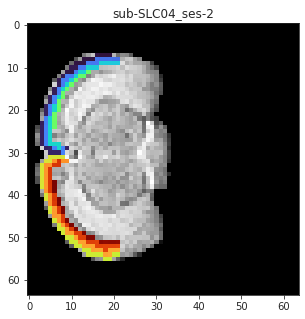

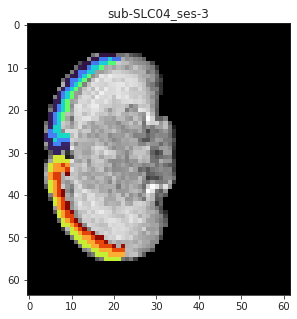

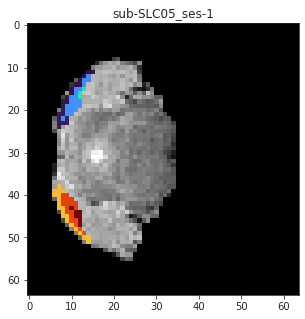

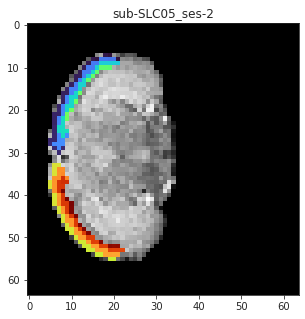

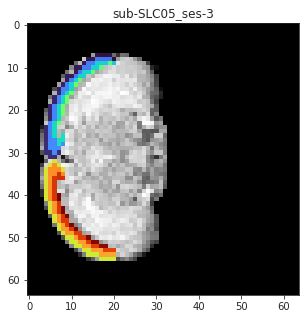

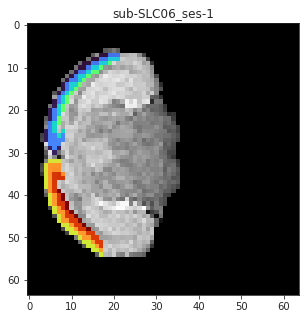

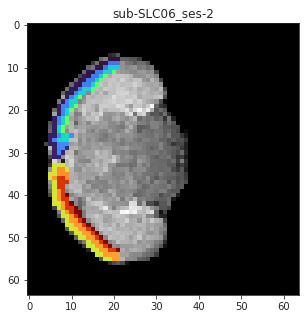

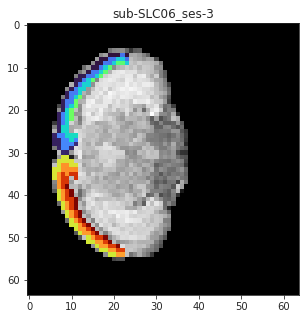

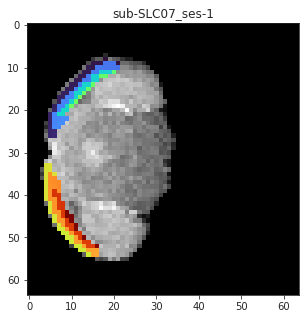

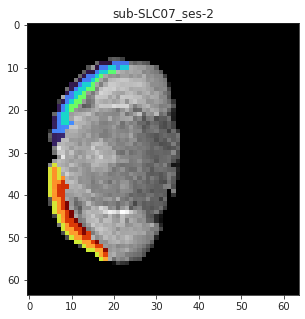

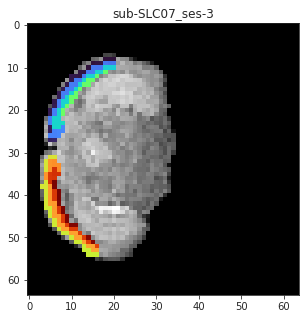

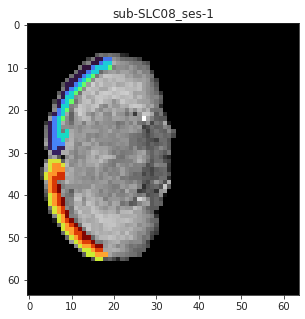

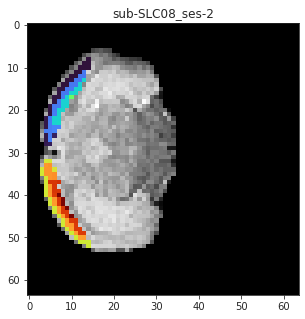

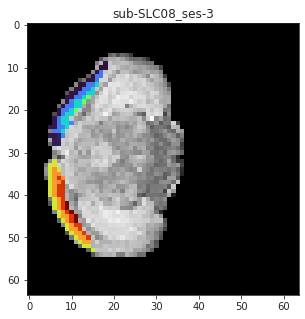

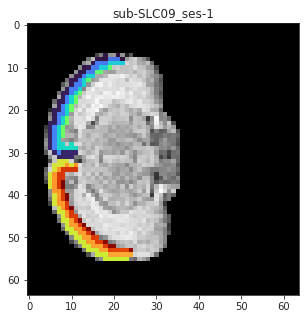

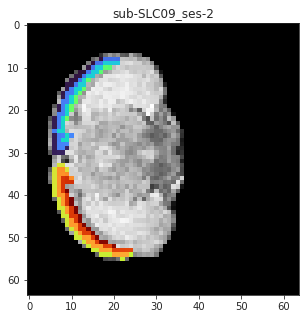

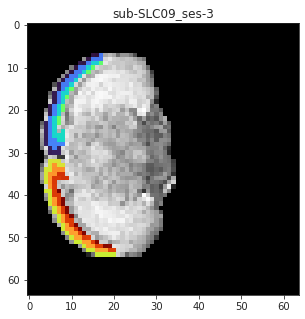

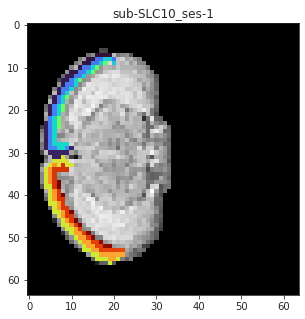

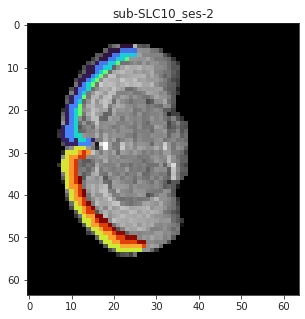

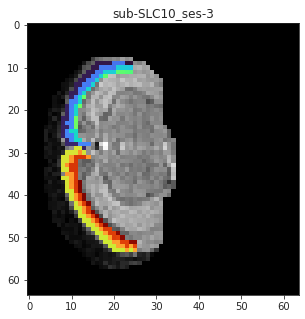

In [80]:
dlist = []
for key, anat in mice.T1w.items():
    file = next(
        f for f in os.listdir(mice.cfg.masks_dir)
        if all(k in f for k in [key, 'cortex-merged'])
    )
    mask = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    x = mask.numpy()
    sizes_indiv = collections.Counter(x[x.nonzero()])
    sizes_indiv = {i: sizes_indiv.get(i, 0) for i in regions}
    
    dlist.append({
        'region': regions,
        'key': [key] * len(regions),
        'vox': sizes_indiv.values(),
    })
    

    plt.figure(figsize=(5, 5))
    data2plt = np.ma.masked_where(~mask.numpy().astype(bool), mask.numpy())
    plt.imshow(anat.get_data()[..., 30], cmap='Greys_r')
    plt.imshow(data2plt[..., 30], cmap='turbo')
    plt.title(key)
    plt.show()
    
df_vox = pd.DataFrame(merge_dicts(dlist))

<AxesSubplot:xlabel='vox', ylabel='Count'>

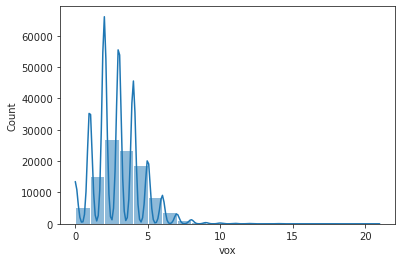

In [83]:
sns.histplot(data=df_vox, x='vox', bins=np.arange(0, 20), kde=True)

In [84]:
df = df_vox.loc[df_vox['vox'] == 0]

In [85]:
missing = dict(collections.Counter(df['region']).most_common())
missing

{
    512: 30,
    1045: 30,
    2560: 30,
    3633: 30,
    3647: 30,
    3093: 29,
    1585: 28,
    1676: 28,
    1599: 27,
    2589: 27,
    1477: 26,
    2497: 26,
    2559: 26,
    407: 25,
    410: 25,
    474: 25,
    507: 25,
    1775: 25,
    1844: 25,
    3525: 25,
    3800: 25,
    3823: 25,
    389: 24,
    391: 24,
    2554: 24,
    2557: 24,
    181: 23,
    449: 23,
    511: 23,
    541: 23,
    1166: 23,
    3594: 23,
    1003: 22,
    2555: 22,
    3724: 22,
    131: 22,
    155: 21,
    498: 21,
    505: 21,
    508: 21,
    2548: 21,
    2556: 21,
    2558: 21,
    2577: 21,
    4048: 21,
    305: 20,
    2455: 20,
    45: 20,
    500: 20,
    506: 20,
    510: 20,
    258: 19,
    1546: 19,
    1752: 19,
    2512: 19,
    2546: 19,
    2553: 19,
    2093: 19,
    1888: 18,
    2000: 18,
    3892: 18,
    3919: 18,
    1041: 18,
    2418: 18,
    3089: 18,
    3051: 18,
    281: 17,
    1697: 17,
    3865: 17,
    1817: 17,
    2400: 16,
    2468: 16,
    2522: 16,
    209: 16,
    105: 15,
    233: 15,
    355: 15,
    387: 15,
    485: 15,
    533: 15,
    961: 15,
    509: 15,
    2865: 15,
    1686: 15,
    3544: 15,
    1488: 15,
    333: 14,
    529: 14,
    2188: 14,
    2519: 14,
    3033: 14,
    3039: 14,
    3734: 14,
    991: 14,
    2065: 14,
    1459: 14,
    3507: 14,
    464: 14,
    493: 13,
    1899: 13,
    2356: 13,
    3012: 13,
    3034: 13,
    3214: 13,
    3635: 13,
    3954: 13,
    985: 13,
    335: 13,
    1448: 13,
    1601: 13,
    1906: 13,
    1923: 13,
    1936: 13,
    2982: 13,
    140: 13,
    370: 12,
    1496: 12,
    1728: 12,
    2153: 12,
    3950: 12,
    124: 12,
    471: 12,
    1760: 12,
    3936: 12,
    1425: 12,
    1617: 12,
    1930: 12,
    473: 11,
    1374: 11,
    1451: 11,
    1862: 11,
    2435: 11,
    2539: 11,
    3516: 11,
    3745: 11,
    3834: 11,
    3868: 11,
    3932: 11,
    216: 11,
    502: 11,
    868: 11,
    1871: 11,
    1896: 11,
    2172: 11,
    3062: 11,
    1857: 11,
    1903: 11,
    1914: 11,
    63: 10,
    90: 10,
    452: 10,
    958: 10,
    1006: 10,
    1395: 10,
    3931: 10,
    3967: 10,
    3990: 10,
    1019: 10,
    1449: 10,
    1806: 10,
    3040: 10,
    3536: 10,
    3617: 10,
    352: 10,
    374: 10,
    477: 10,
    1879: 10,
    3067: 10,
    3695: 10,
    1916: 10,
    3477: 10,
    3910: 10,
    900: 10,
    2893: 10,
    986: 10,
    845: 10,
    1468: 9,
    1805: 9,
    1861: 9,
    1883: 9,
    2209: 9,
    2521: 9,
    2533: 9,
    3930: 9,
    4003: 9,
    1884: 9,
    1913: 9,
    2138: 9,
    2916: 9,
    3009: 9,
    3490: 9,
    3853: 9,
    930: 9,
    1192: 9,
    1900: 9,
    1908: 9,
    1917: 9,
    1942: 9,
    1990: 9,
    2500: 9,
    3590: 9,
    3808: 9,
    49: 9,
    2527: 9,
    420: 9,
    479: 9,
    2264: 9,
    17: 8,
    161: 8,
    820: 8,
    1306: 8,
    1635: 8,
    1832: 8,
    1856: 8,
    1882: 8,
    1966: 8,
    2550: 8,
    2616: 8,
    3240: 8,
    3496: 8,
    3776: 8,
    3909: 8,
    3974: 8,
    1902: 8,
    1983: 8,
    2077: 8,
    2097: 8,
    2551: 8,
    817: 8,
    1305: 8,
    1820: 8,
    3948: 8,
    308: 8,
    673: 8,
    2650: 8,
    1821: 8,
    1919: 8,
    3957: 8,
    1406: 8,
    1887: 8,
    964: 8,
    3951: 8,
    940: 7,
    1701: 7,
    1915: 7,
    1931: 7,
    2541: 7,
    2635: 7,
    3337: 7,
    3497: 7,
    3983: 7,
    1164: 7,
    1647: 7,
    3311: 7,
    3665: 7,
    617: 7,
    1014: 7,
    1929: 7,
    2544: 7,
    3971: 7,
    3978: 7,
    1934: 7,
    2240: 7,
    526: 7,
    1932: 7,
    2450: 7,
    3276: 7,
    1909: 7,
    3683: 7,
    3959: 7,
    4038: 7,
    1429: 7,
    22: 6,
    39: 6,
    81: 6,
    453: 6,
    504: 6,
    636: 6,
    1024: 6,
    1587: 6,
    1786: 6,
    2087: 6,
    2329: 6,
    3031: 6,
    3869: 6,
    3935: 6,
    4014: 6,
    882: 6,
    1442: 6,
    1901: 6,
    1933: 6,
    1994: 6,
    2111: 6,
    2536: 6,
    2634: 6,
    3059: 6,
    3091: 6,
    1940: 6,
    2124: 6,
    2374: 6,
    2552

{
    833: 28,
    1857: 28,
    212: 27,
    1236: 27,
    1280: 24,
    256: 23,
    1297: 23,
    163: 19,
    145: 17,
    1797: 14,
    178: 12,
    773: 11,
    273: 11,
    1458: 10,
    1545: 9,
    1277: 8,
    1246: 8,
    1937: 7,
    2001: 7,
    239: 6,
    977: 6,
    434: 6,
    504: 6,
    1274: 6,
    253: 6,
    1263: 5,
    128: 4,
    581: 4,
    1192: 4,
    1605: 4,
    1959: 4,
    1984: 4,
    935: 4,
    1443: 4,
    521: 4,
    1745: 4,
    1448: 4,
    168: 4,
    947: 4,
    480: 3,
    913: 3,
    954: 3,
    1968: 3,
    940: 3,
    1528: 3,
    487: 3,
    956: 3,
    255: 3,
    1982: 3,
    952: 3,
    1999: 3,
    254: 3,
    1871: 3,
    919: 3,
    335: 3,
    1899: 3,
    222: 3,
    250: 2,
    478: 2,
    922: 2,
    948: 2,
    1270: 2,
    435: 2,
    179: 2,
    1279: 2,
    1920: 2,
    183: 2,
    705: 2,
    1978: 2,
    233: 2,
    1976: 2,
    1278: 2,
    1203: 2,
    691: 2,
    78: 2,
    424: 2,
    718: 2,
    885: 2,
    938: 2,
    1981: 2,
    113: 2,
    930: 2,
    1492: 1,
    1502: 1,
    1980: 1,
    769: 1,
    958: 1,
    1925: 1,
    266: 1,
    729: 1,
    1050: 1,
    201: 1,
    1060: 1,
    1202: 1,
    960: 1,
    1971: 1,
    252: 1,
    1482: 1,
    704: 1,
    1513: 1,
    1735: 1,
    1336: 1,
    1504: 1,
    1715: 1,
    975: 1,
    64: 1,
    1898: 1,
    1276: 1,
    2007: 1,
    944: 1,
    1973: 1,
    937: 1,
    957: 1,
    1983: 1,
    1990: 1,
    1425: 1,
    1974: 1,
    912: 1,
    1873: 1,
    321: 1,
    847: 1,
    849: 1,
    955: 1,
    679: 1,
    959: 1,
    1456: 1,
    1649: 1,
    1965: 1,
    312: 1,
    894: 1,
    896: 1,
    943: 1,
    964: 1,
    1945: 1,
    1531: 1,
    1786: 1,
    949: 1,
    950: 1,
    874: 1,
    1918: 1
}

In [87]:
mice.parcel.decode(list(missing))[0][:20]

array([[  1, 512,   0],
       [  1,  21,   2],
       [  2, 512,   0],
       [  2,  49,   3],
       [  2,  63,   3],
       [  2,  21,   2],
       [  1,  49,   3],
       [  1, 140,   3],
       [  1,  63,   3],
       [  2,  29,   1],
       [  1, 453,   2],
       [  2, 449,   0],
       [  2, 511,   0],
       [  1, 407,   0],
       [  1, 410,   0],
       [  1, 474,   0],
       [  1, 507,   0],
       [  1, 239,   3],
       [  1, 308,   3],
       [  2, 453,   2]])

<AxesSubplot:ylabel='Count'>

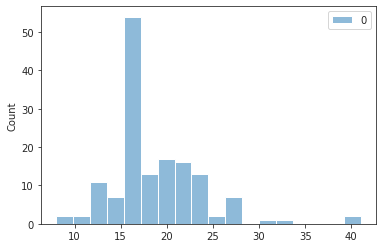

In [88]:
sns.histplot({i: sizes[i] for i in missing if missing[i] > 10}.values())

[PROGRESS] fit columnar: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

[PROGRESS] save 2D 10um: done

[PROGRESS] 2d --> 3d: done

[PROGRESS] fill gaps: done

[PROGRESS] save 3D 10um: done

[PROGRESS] downsample: done

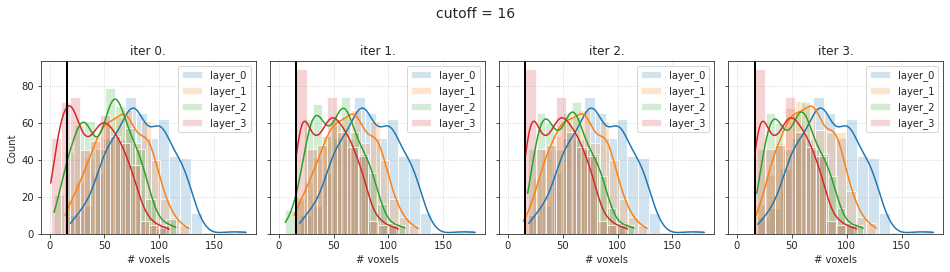

[PROGRESS] merge: done

Warning, region '163' is flat

Warning, region '178' is flat

Warning, region '193' is flat

[PROGRESS] erode: done

num merged regions,     left: 969,  right: 969
region id diff,         r - l:  Counter({1024: 969})

[PROGRESS] fit columnar: done

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*4

[PROGRESS] save results: done.

In [3]:
"""start = time()

kwargs = {'cutoff': 16}
mice.parcel.fit_parcel(force_fit=True, **kwargs)

end = time()"""

In [4]:
convert_time(end - start)

00 - 00:26:14  (dd - hh:mm:ss)

In [5]:
from register.register import Register
reg = Register(mice)

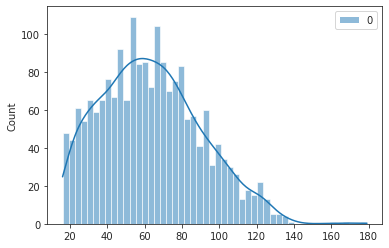

In [6]:
cortex = mice.parcel.results['cortex-merged']
regions = mice.parcel.results['merged-regions']

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

sns.histplot(sizes.values(), bins=50, kde=True)
plt.show()

In [7]:
(sizes_np > 140).sum(),(sizes_np <= 140).sum()

(3, 1935)

In [8]:
hcl, hcl_d = mice.parcel.decode(regions)
len(hcl)

1938

In [9]:
delta = []
delta_norm = []
bad_regions = []
for i in regions:
    hh, cc, ll = hcl_d[i]
    if hh == 1:
        mirror = mice.parcel.encode(2, cc, ll)
        sz_r = sizes[mirror]
        sz_l = sizes[i]
        
        diff = sz_l - sz_r
        delta.append(diff)
        
        diff_n = abs(diff) / min(sz_l, sz_r)
        delta_norm.append(diff_n)
        
        if diff_n > 0.5:
            bad_regions.append(i)

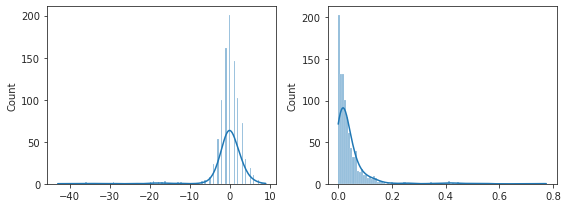

In [10]:
fig, axes = create_figure(1, 2, (8, 3))
sns.histplot(delta, kde=True, ax=axes[0])
sns.histplot(delta_norm, kde=True, ax=axes[1])
plt.show()

In [11]:
100 * ((np.array(delta_norm) > 0.1).sum() / len(regions) / 2)

2.1671826625387

In [12]:
bad_regions

[145, 153, 163, 178, 193, 206]

In [13]:
bad_regions = mice.parcel.complement(bad_regions)
bad_regions

array([ 145,  153,  163,  178,  193,  206, 1169, 1177, 1187, 1202, 1217,
       1230], dtype=uint32)

In [14]:
hcl, _ = mice.parcel.decode()
len(hcl)

1938

## Render

In [12]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

cmap = sns.color_palette('turbo', as_cmap=True)

alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [13]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = f'columnar_n{mice.cfg.n_hemisphere_regions}*{mice.cfg.n_parcel_layers}'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for i, region_id in enumerate(regions):
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n256*4_k1938.html

In [14]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = f'columnar_n{mice.cfg.n_hemisphere_regions}*{mice.cfg.n_parcel_layers}_columns'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
cols = np.unique(hcl[:, 1])
for i, cc in enumerate(cols):
    ids = []
    for ll in range(mice.cfg.n_parcel_layers):
        ids.append(mice.parcel.encode(1, cc, ll))
        ids.append(mice.parcel.encode(2, cc, ll))
    x = np.isin(cortex, ids)
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(cols))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{cc}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(cols)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n256*4_columns_k256.html

In [15]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = f'columnar_n{mice.cfg.n_hemisphere_regions}*{mice.cfg.n_parcel_layers}_layers'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
cols = np.unique(hcl[:, 1])
layers = np.unique(hcl[:, 2])
for i, ll in enumerate(layers):
    ids = []
    for cc in cols:
        ids.append(mice.parcel.encode(1, cc, ll))
    x = np.isin(cortex, ids)
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(layers))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{ll}")
for i, ll in enumerate(layers):
    ids = []
    for cc in cols:
        ids.append(mice.parcel.encode(2, cc, ll))
    x = np.isin(cortex, ids)
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(layers))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{ll}")

scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(layers)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n256*4_layers_k4.html

[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

Warning! missing regions:
'[1596, 1597, 3629, 3644, 3645, 3656, 4079]'

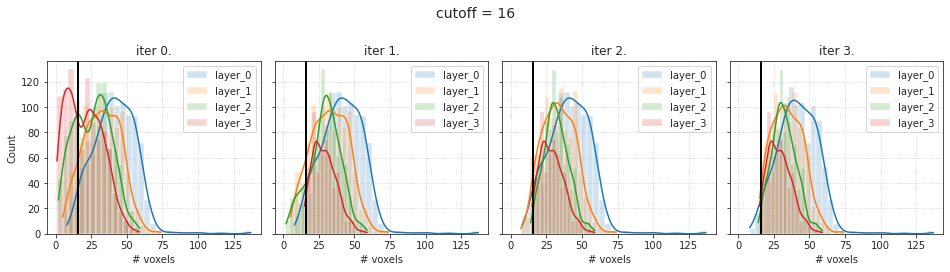

[PROGRESS] merge: done

Warning, region '305' is flat

Warning, region '389' is flat

Warning, region '391' is flat

Warning, region '410' is flat

[PROGRESS] erode: done

num merged regions,     left: 1740,  right: 1740
region id diff,         r - l:  Counter({2048: 1740})

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*4

[PROGRESS] save results: done.

In [4]:
kwargs = {'cutoff': 16, 'ants_downsample': True}
mice.parcel.fit_parcel(force_fit=True, **kwargs)

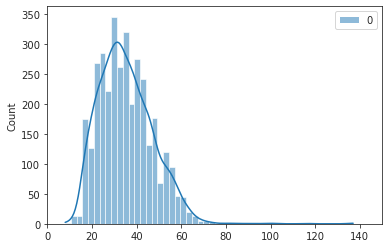

In [5]:
cortex = mice.parcel.results['cortex-merged']
regions = mice.parcel.results['merged-regions']

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

sns.histplot(sizes.values(), bins=50, kde=True)
plt.xlim(0, 150)
plt.show()

In [6]:
hcl, hcl_d = mice.parcel.decode(regions)
len(hcl)

3480

In [7]:
delta = []
delta_norm = []
bad_regions = []
for i in regions:
    hh, cc, ll = hcl_d[i]
    if hh == 1:
        mirror = mice.parcel.encode(2, cc, ll)
        sz_r = sizes[mirror]
        sz_l = sizes[i]
        
        diff = sz_l - sz_r
        delta.append(diff)
        
        diff_n = abs(diff) / min(sz_l, sz_r)
        delta_norm.append(diff_n)
        
        if diff_n > 0.50:
            bad_regions.append(i)

<AxesSubplot:ylabel='Count'>

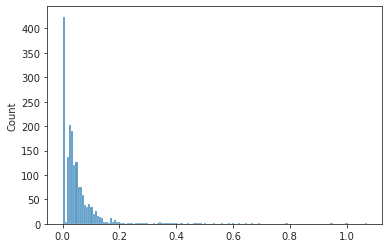

In [8]:
sns.histplot(delta_norm)

In [9]:
(np.array(delta_norm) > 0.1).sum(), len(regions) / 2

(200, 1740.0)

In [13]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

cmap = sns.color_palette('turbo', as_cmap=True)

alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [14]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n512*4_bad_regions_whenyounot-dothat'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')
    
surfaces, names, colors = [], [], []
#for i, region_id in tqdm(enumerate(result['cortex-merged-regions'])):
for region_id in bad_regions:
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n512*4_bad_regions_whenyounot-d
othat_k3480.html

In [26]:
parcel3d = np.load(pjoin(cfg.main_dir, 'parcel3d_10um.npy'))

In [27]:
sizes10 = collections.Counter(parcel3d[parcel3d.nonzero()])
sizes10_np = np.array(list(sizes10.values()))

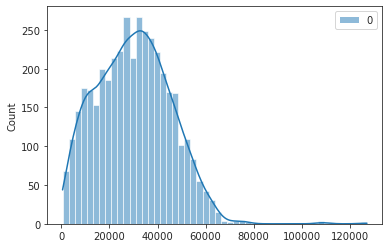

In [28]:
sns.histplot(sizes10.values(), bins=50, kde=True)
plt.show()

In [31]:
hcl, hcl_d = mice.parcel.decode()

In [32]:
bad_regions

array([ 131,  181,  270,  290,  305,  311,  335,  355,  374,  389,  391,
        410, 2179, 2229, 2318, 2338, 2353, 2359, 2383, 2403, 2422, 2437,
       2439, 2458], dtype=uint32)

In [33]:
delta = []
delta_norm = []
bad_regions10 = []
for i in regions:
    hh, cc, ll = hcl_d[i]
    if hh == 1:
        mirror = mice.parcel.encode(2, cc, ll)
        sz_r = sizes10[mirror]
        sz_l = sizes10[i]
        
        diff = sz_l - sz_r
        delta.append(diff)
        
        diff_n = abs(diff) / min(sz_l, sz_r)
        delta_norm.append(diff_n)
        
        if diff_n > 0.5:
            bad_regions10.append(i)

<AxesSubplot:ylabel='Count'>

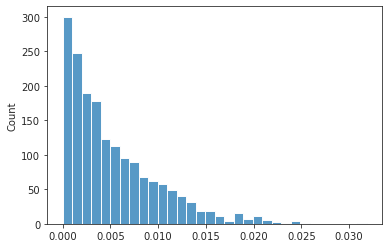

In [34]:
sns.histplot(delta_norm)

(10, 10, 10)

In [35]:
from skimage.measure import block_reduce

In [44]:
parcel3d_nan = parcel3d.copy().astype(float)
parcel3d_nan[parcel3d == 0] = np.nan

In [62]:
test = block_reduce(parcel3d_nan, (10.0, 10.0, 10.0), np.nanmedian)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
test.shape

<matplotlib.image.AxesImage object at 0x7f90d46f5d30>

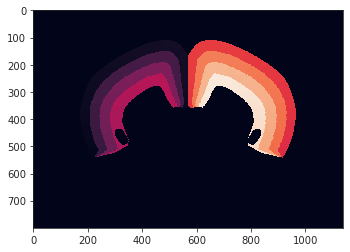

In [47]:
plt.imshow(parcel3d[400])

<matplotlib.image.AxesImage object at 0x7f90fc59cfa0>

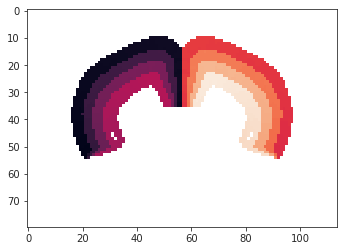

In [48]:
plt.imshow(test[40])

In [49]:
test *= mice.al.iso_mask

<matplotlib.image.AxesImage object at 0x7f91240b99d0>

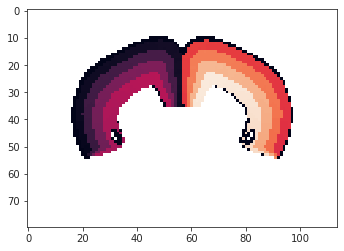

In [50]:
plt.imshow(test[40])

In [51]:
test[np.isnan(test)] = 0.0
test = test.astype('uint32')

<matplotlib.image.AxesImage object at 0x7f91240b1100>

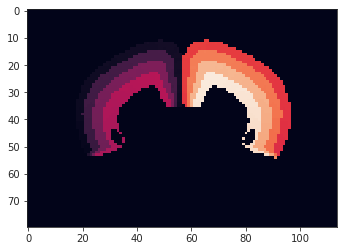

In [52]:
plt.imshow(test[40])

In [54]:
from register.parcellation import fill_img

In [55]:
invalid = np.logical_and(test == 0, mice.al.iso_mask)
test = fill_img(test, invalid)
test[~mice.al.iso_mask] = 0

<matplotlib.image.AxesImage object at 0x7f90d43e3fd0>

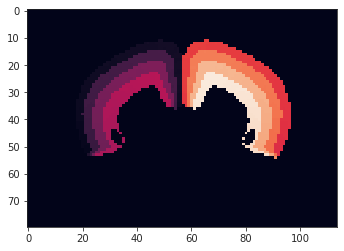

In [56]:
plt.imshow(test[40])

In [59]:
100 % 10

0

In [60]:
25 % 10

5

<matplotlib.image.AxesImage object at 0x7f91241209d0>

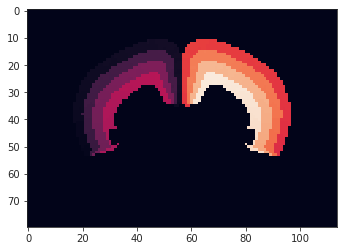

In [62]:
al10 = Allen(10, full_load=True)

In [63]:
from register.register import *


In [64]:
parcel3d_img = reset_ants_img(parcel3d, spacing=10)
parcel3d_img

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (1320, 800, 1140)
         Spacing    : (10.0, 10.0, 10.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [66]:
test = ants.resample_image(
    image=parcel3d_img,
    resample_params=[10] * 3,
    interp_type=1,
)

In [67]:
test

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (1320, 800, 1140)
         Spacing    : (10.0, 10.0, 10.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7f9e8d739ca0>

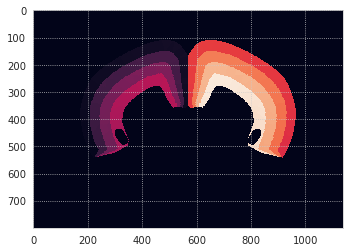

In [69]:
plt.imshow(parcel3d_img[400])

<matplotlib.image.AxesImage object at 0x7f9e8d796d00>

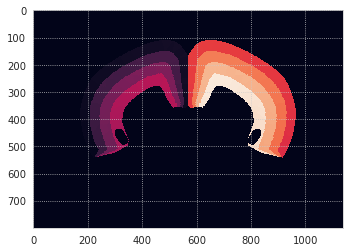

In [68]:
plt.imshow(test[400])

In [135]:
num = mice.cfg.n_hemisphere_regions * mice.cfg.n_parcel_layers
num

2048

In [148]:
cortex_l = cortex[mice.al.slices_l].astype(float)
cortex_r = cortex[mice.al.slices_r].astype(float)

cortex_sym = cortex_r - num
cortex_sym[cortex_r == 0.] = 0.
cortex_sym += np.flip(cortex_l, 2)
cortex_sym = np.round(cortex_sym / 2)

cortex_full = cortex.copy().astype(float)
cortex_full[mice.al.slices_r] = cortex_sym + num
cortex_full[mice.al.slices_l] = np.flip(cortex_sym, 2)
cortex_full[cortex == 0] = 0.
cortex_full = cortex_full.astype('uint32')

<matplotlib.colorbar.Colorbar object at 0x7f9e780f5b20>

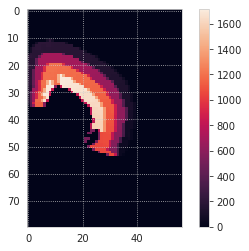

In [149]:
plt.imshow(cortex_sym[40])
plt.colorbar()

In [150]:
cortex_full.shape

(132, 80, 114)

<matplotlib.image.AxesImage object at 0x7f9e780b3e20>

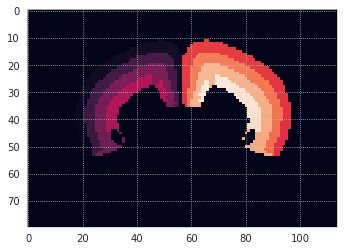

In [151]:
plt.imshow(cortex[40])

<matplotlib.image.AxesImage object at 0x7f9e78058520>

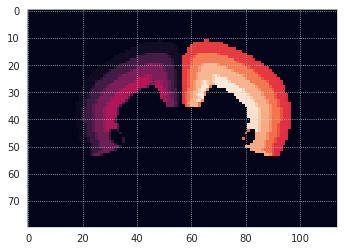

In [152]:
plt.imshow(cortex_full[40])

In [154]:
cortex_full[cortex_full.nonzero()].ravel()

array([  59,   59,   59, ..., 3032, 2520, 2284], dtype=uint32)

<AxesSubplot:ylabel='Count'>

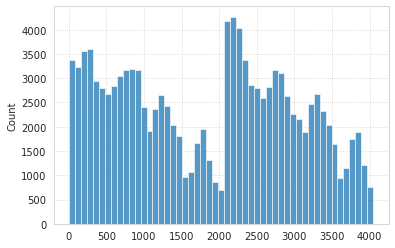

In [155]:
sns.histplot(cortex_full[cortex_full.nonzero()].ravel())

In [156]:
sizes = collections.Counter(cortex_full[cortex_full.nonzero()])
sizes_np = np.array(list(sizes.values()))

In [157]:
len(sizes)

3938

In [158]:
len()

3480

In [159]:
regions = np.unique(cortex_full[cortex_full.nonzero()])

In [161]:
hcl, hcl_d = mice.parcel.decode(regions)

In [162]:
delta = []
delta_norm = []
bad_regions = []
for i in regions:
    hh, cc, ll = hcl_d[i]
    if hh == 1:
        mirror = mice.parcel.encode(2, cc, ll)
        sz_r = sizes[mirror]
        sz_l = sizes[i]
        
        diff = sz_l - sz_r
        delta.append(diff)
        
        diff_n = abs(diff) / min(sz_l, sz_r)
        delta_norm.append(diff_n)
        
        if diff_n > 0.5:
            bad_regions.append(i)

<AxesSubplot:ylabel='Count'>

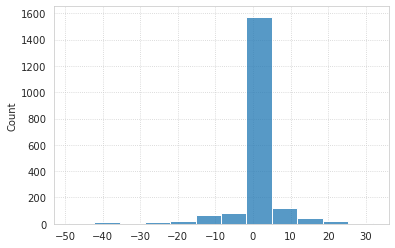

In [163]:
sns.histplot(delta)

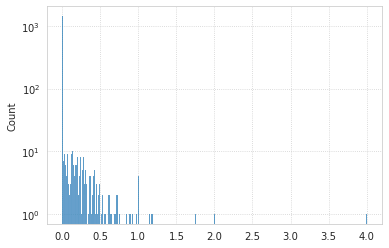

In [166]:
sns.histplot(delta_norm)
plt.yscale('log')

In [167]:
(np.array(delta_norm) > 0.1).sum(), len(regions) / 2

(394, 1969.0)

In [168]:
bad_regions

[
    3,
    24,
    34,
    36,
    42,
    45,
    50,
    52,
    56,
    61,
    63,
    64,
    74,
    77,
    80,
    86,
    87,
    94,
    98,
    100,
    105,
    106,
    111,
    118,
    126,
    128,
    130,
    131,
    136,
    138,
    144,
    146,
    148,
    150,
    154,
    156,
    160,
    161,
    172,
    174,
    180,
    188,
    190,
    206,
    216,
    557,
    838,
    843,
    845,
    848,
    862,
    866,
    874,
    881,
    882,
    884,
    886,
    894,
    896,
    898,
    899,
    900,
    901,
    904,
    906,
    910,
    912,
    917,
    920,
    922,
    928,
    931,
    932,
    937,
    940,
    944,
    948,
    950,
    956,
    984,
    986,
    993
]

In [48]:
bad_regions = mice.parcel.complement(bad_regions)
bad_regions

array([ 131,  181,  270,  290,  305,  311,  335,  355,  374,  389,  391,
        410, 2179, 2229, 2318, 2338, 2353, 2359, 2383, 2403, 2422, 2437,
       2439, 2458], dtype=uint32)

In [49]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

cmap = sns.color_palette('turbo', as_cmap=True)

alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [50]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n512*4_bad_regions'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')
    
surfaces, names, colors = [], [], []
#for i, region_id in tqdm(enumerate(result['cortex-merged-regions'])):
for region_id in bad_regions:
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n512*4_bad_regions_k3480.html

In [ ]:
"""start = time()
parcel = Parcellation(cfg, full_load=True)
end = time()"""

[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

Warning! missing regions:
'[1596, 1597, 3629, 3644, 3645, 3656, 4079]'

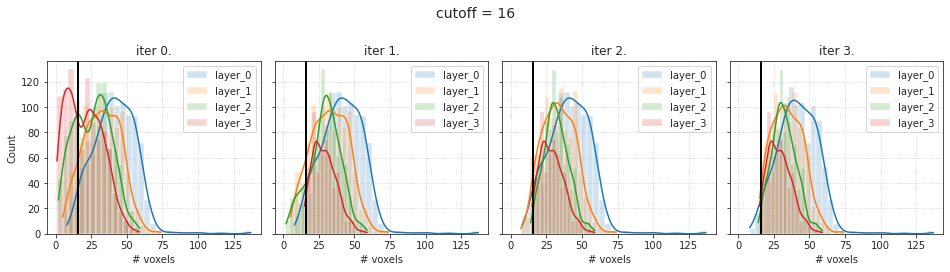

[PROGRESS] merge: done

Warning, region '305' is flat

Warning, region '389' is flat

Warning, region '391' is flat

Warning, region '410' is flat

[PROGRESS] erode: done

num merged regions,     left: 1740,  right: 1740
region id diff,         r - l:  Counter({2048: 1740})

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*4

[PROGRESS] save results: done.

In [60]:
"""start = time()

kwargs = {'cutoff': 16}
parcel.fit_parcel(force_fit=True, **kwargs)

end = time()"""

In [61]:
convert_time(end - start)

00 - 00:01:34  (dd - hh:mm:ss)

In [35]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

cmap = sns.color_palette('turbo', as_cmap=True)

alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [ ]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n512*4_cutoff20'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')
    
surfaces, names, colors = [], [], []
#for i, region_id in tqdm(enumerate(result['cortex-merged-regions'])):
for region_id in regions:
    x = parcel.results['cortex-merged'] == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(parcel.results['merged-regions']))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

In [38]:
regions

[305, 389, 391, 410, 2353, 2437, 2439, 2458]

<AxesSubplot:ylabel='Count'>

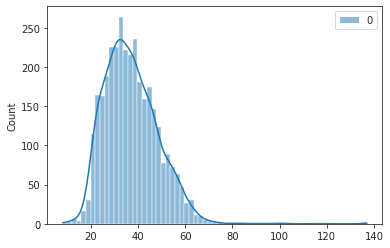

In [56]:
regions = [i for i, v in sizes.items() if v > 80]
mirror = []
for hh, cc, ll  in parcel.decode(regions)[0]:
    mirror.append(parcel.encode(2 if hh == 1 else 1, cc, ll))
regions += mirror
regions = list(set(regions))
regions

[68, 2116, 41, 2089, 11, 2059, 2099, 51, 2136, 88]

In [57]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n512*4_cutoff20_largest'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')
    
surfaces, names, colors = [], [], []
#for i, region_id in tqdm(enumerate(result['cortex-merged-regions'])):
for region_id in regions:
    x = parcel.results['cortex-merged'] == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(parcel.results['merged-regions']))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n512*4_cutoff20_largest_k10.html

In [97]:
missing = set(range(1, 1 + 4096)).difference(set(parcel.results['cortex-regions']))
missing = list(missing)

In [99]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n512*4_cutoff20_missing'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')
    
surfaces, names, colors = [], [], []
#for i, region_id in tqdm(enumerate(result['cortex-merged-regions'])):
for region_id in missing:
    x = parcel.results['cortex-merged'] == region_id
    print(x.sum())
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(parcel.results['merged-regions']))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

0

0

0

0

0

0

0

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n512*4_cutoff20_missing_k8.html

In [111]:
missing

[1597, 3656, 3629, 4079, 1596, 3645, 3644]

In [113]:
merged_reg = list(np.unique(x[x.nonzero()]))

In [114]:
[i for i in missing if i in merged_reg]

[]

In [115]:
len(merged_reg)

3312

In [116]:
elim = [e for i, (_, e) in parcel.results['merged-ids'].items()]
len(elim), len(set(elim))

(780, 780)

In [117]:
[i for i in missing if i in elim]

[3656, 3629, 4079]

In [118]:
sizes = collections.Counter(
    parcel.results['cortex'][parcel.results['cortex'].nonzero()])

In [119]:
[i for i in missing if i in sizes]

[]

In [142]:
def f(hh):
    return hh % 2 + 1

In [143]:
f(1), f(2)

(2, 1)

In [129]:
symmetric = False
layer = 3
hcl = parcel.decode()[0]

cond = hcl[:, -1] == layer
if symmetric:
    cond &= hcl[:, 0] == 1
cond.sum()

1017

In [130]:
symmetric = True
layer = 3
hcl = parcel.decode()[0]

cond = hcl[:, -1] == layer
if symmetric:
    cond &= hcl[:, 0] == 1
cond.sum()

510

In [28]:
flat = [
    163, 178, 193, 788, 799, 802, 807, 821, 840,
    870, 1011, 1017, 1785, 1812, 1823, 1826, 1831,
    1845, 1849, 1864, 1894, 2035, 2040, 2041,
]

In [29]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [30]:
alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n256*4_flats'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for region_id in tqdm(flat):
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap((region_id - 1) / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/24 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n256*4_flats_k2048.html

## Merge bad roi's to higher layers

In [4]:
flat = [
    163, 178, 193, 788, 799, 802, 807, 821, 840,
    870, 1011, 1017, 1785, 1812, 1823, 1826, 1831,
    1845, 1849, 1864, 1894, 2035, 2040, 2041,
]
cortex = parcel.results['cortex'].copy()
regions = parcel.results['cortex-regions'].copy()

In [5]:
list(parcel.results)

[
    'cortex-regions',
    'cortex',
    'cortex-eroded',
    'subcortex',
    'major_masks',
    'n_cortical_regions',
    'radius',
    'major_colors',
    'cmap'
]

In [8]:
sizes = {i: (cortex == i).sum() for i in parcel.results['cortex-regions']}

<matplotlib.lines.Line2D object at 0x7f0c19507fd0>

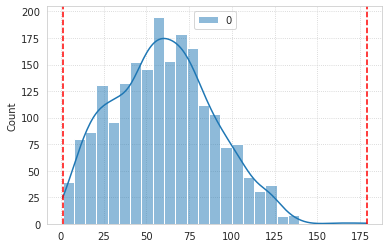

In [9]:
sns.histplot(sizes.values(), kde=True)
plt.axvline(min(sizes.values()), color='r', ls='--')
plt.axvline(max(sizes.values()), color='r', ls='--')

In [10]:
hcl = parcel.decode()
hcl_dict = {i + 1: v for i, v in enumerate(hcl)}

[
    <matplotlib.lines.Line2D object at 0x7f0c19439520>,
    <matplotlib.lines.Line2D object at 0x7f0c19439610>
]

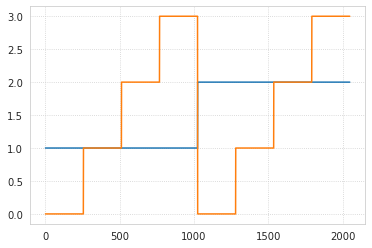

In [11]:
plt.plot(hcl[:, [0, 2]])

In [12]:
hcl

array([[  1,   1,   0],
       [  1,   2,   0],
       [  1,   3,   0],
       ...,
       [  2, 254,   3],
       [  2, 255,   3],
       [  2, 256,   3]])

In [13]:
layer4 = regions[hcl[:, -1] == 3]

In [14]:
sizes_np = np.array(list(sizes.values()))

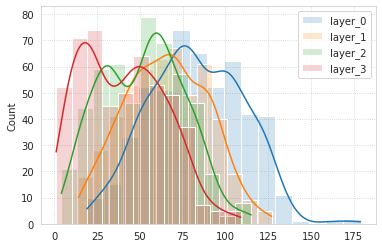

In [15]:
for i in range(4):
    sns.histplot(sizes_np[hcl[:, -1] == i], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.legend()
plt.show()

In [16]:
np.quantile(sizes_np[hcl[:, -1] == 3], 0.5)

39.0

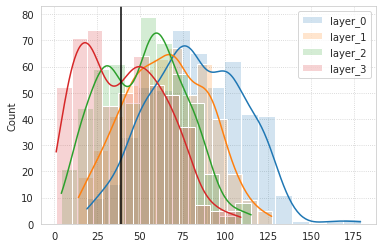

In [17]:
for i in range(4):
    sns.histplot(sizes_np[hcl[:, -1] == i], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.axvline(np.quantile(sizes_np[hcl[:, -1] == 3], 0.5), color='k')
plt.legend()
plt.show()

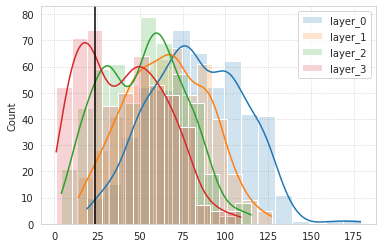

In [98]:
for i in range(4):
    sns.histplot(sizes_np[hcl[:, -1] == i], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.axvline(cutoff, color='k')
plt.legend()
plt.show()

In [100]:
list()

[3, 2, 1, 0]

In [11]:
list()

[3, 2, 1]

In [36]:
def merge_regions(cortex, regions, cutoff: int = 24):
    hcl = parcel.decode(regions)
    hcl_dict = {i + 1: v for i, v in enumerate(hcl)}
    
    sizes = {
        i: (cortex == i).sum()
        for i in regions
    }
    sizes_np = np.array(list(sizes.values()))
    
    fig, axes = create_figure(1, 4, (13.3, 3.1), 'all', 'all')
    for i in range(4):
        data2plt = sizes_np[hcl[:, -1] == i]
        sns.histplot(data2plt[data2plt.nonzero()], kde=True,
                     color=f"C{i}", alpha=0.2, label=f"layer_{i}", ax=axes[0])
        axes[0].axvline(cutoff, color='k')
        axes[0].set_title(f"iter 0.")
        axes[0].legend()
    
    x = cortex.copy()
    merged = collections.defaultdict(tuple)
    for iter_i, layer in enumerate(range(1, 4)[::-1], start=1):
        for region in regions[hcl[:, -1] == layer]:
            if sizes[region] < cutoff:
                hh, cc, ll = hcl_dict[region]
                upper = parcel.encode(hh, cc, ll - 1)
                x[x == region] = upper

                merged[upper] += (upper, region)

        sizes = {
            i: (x == i).sum()
            for i in regions
        }
        sizes_np = np.array(list(sizes.values()))

        for i in range(4):
            data2plt = sizes_np[hcl[:, -1] == i]
            sns.histplot(data2plt[data2plt.nonzero()], kde=True,
                         color=f"C{i}", alpha=0.2, label=f"layer_{i}", ax=axes[iter_i])
            axes[iter_i].axvline(cutoff, color='k')
            axes[iter_i].set_title(f"iter {iter_i}.")
            axes[iter_i].legend()

    for ax in axes.ravel():
        ax.set_xlabel('# voxels')
        ax.grid()
    plt.show()

    regions_final = np.unique(x[x.nonzero()])
    
    return x, regions_final

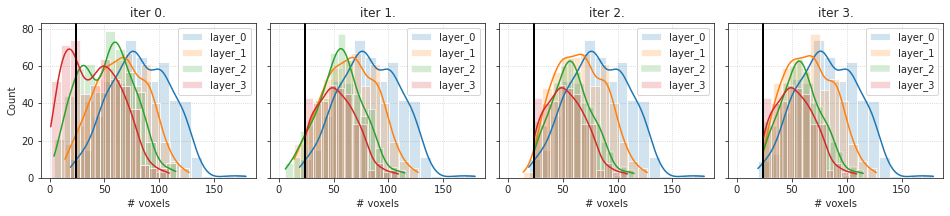

In [37]:
x, regions_final = merge_regions(cortex, regions, 24)

In [38]:
len(regions_final)

1846

KeyError: 1848

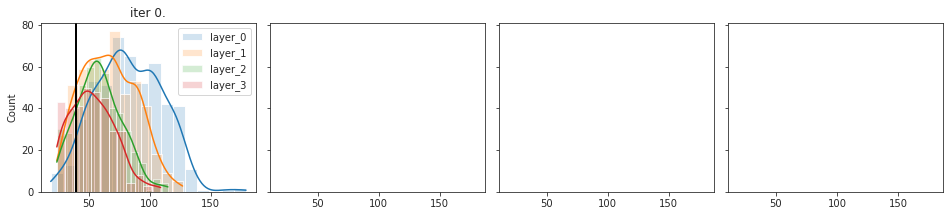

In [39]:
x, regions_final = merge_regions(x, regions_final, 40)

In [ ]:
len(regions_final)

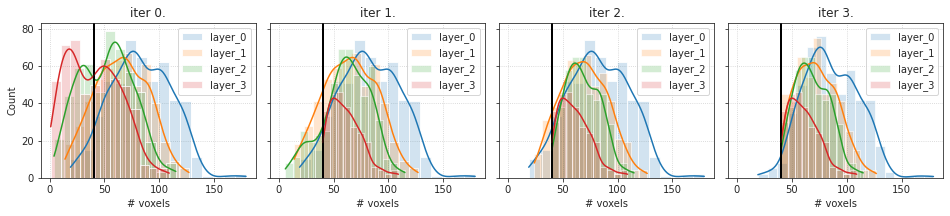

1659

In [91]:
cutoff = 24

In [92]:
cortex_merged = cortex.copy()
merged = collections.defaultdict(tuple)

for region in regions[hcl[:, -1] == 3]:
    if sizes[region] < cutoff:
        hh, cc, ll = hcl_dict[region]
        upper = parcel.encode(hh, cc, ll - 1)
        cortex_merged[cortex == region] = upper
        
        merged[upper] += (upper, region)

sizes_merged = {
    i: (cortex_merged == i).sum()
    for i in parcel.results['cortex-regions']
}
sizes_merged_np = np.array(list(sizes_merged.values()))

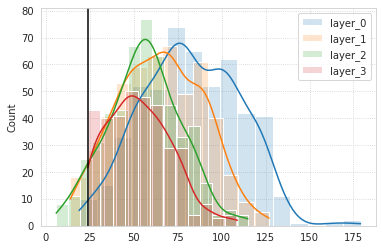

In [93]:
for i in range(4):
    data2plt = sizes_merged_np[hcl[:, -1] == i]
    sns.histplot(data2plt[data2plt.nonzero()], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.axvline(cutoff, color='k')
plt.legend()
plt.show()

In [94]:
for region in regions[hcl[:, -1] == 2]:
    if sizes_merged[region] < cutoff:
        hh, cc, ll = hcl_dict[region]
        upper = parcel.encode(hh, cc, ll - 1)
        cortex_merged[cortex_merged == region] = upper
        
        merged[upper] += (upper, region)
        
sizes_merged = {
    i: (cortex_merged == i).sum()
    for i in parcel.results['cortex-regions']
}
sizes_merged_np = np.array(list(sizes_merged.values()))

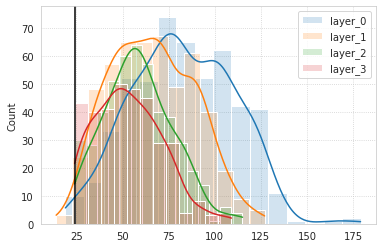

In [95]:
for i in range(4):
    data2plt = sizes_merged_np[hcl[:, -1] == i]
    sns.histplot(data2plt[data2plt.nonzero()], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.axvline(cutoff, color='k')
plt.legend()
plt.show()

In [96]:
for region in regions[hcl[:, -1] == 1]:
    if sizes_merged[region] < cutoff:
        hh, cc, ll = hcl_dict[region]
        upper = parcel.encode(hh, cc, ll - 1)
        cortex_merged[cortex_merged == region] = upper
        
        merged[upper] += (upper, region)
        
sizes_merged = {
    i: (cortex_merged == i).sum()
    for i in parcel.results['cortex-regions']
}
sizes_merged_np = np.array(list(sizes_merged.values()))

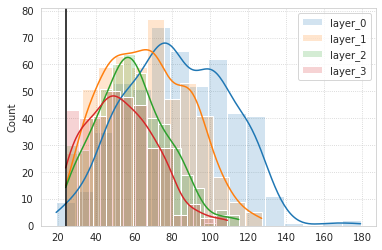

In [97]:
for i in range(4):
    data2plt = sizes_merged_np[hcl[:, -1] == i]
    sns.histplot(data2plt[data2plt.nonzero()], kde=True, color=f"C{i}", alpha=0.2, label=f"layer_{i}")
plt.axvline(cutoff, color='k')
plt.legend()
plt.show()

In [72]:
regions_final = np.unique(cortex_merged[cortex_merged.nonzero()])
len(regions_final)

1659

In [73]:
len(regions)

2048

In [74]:
collections.Counter(decode(parcel, regions)[:, 2])

Counter({0: 512, 1: 512, 2: 512, 3: 512})

In [75]:
collections.Counter(decode(parcel, regions_final)[:, 2])

Counter({0: 512, 1: 465, 2: 431, 3: 251})

In [78]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

cmap = sns.color_palette('turbo', as_cmap=True)

alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [79]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [80]:
alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n256*4_merged'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions_final), total=len(regions_final)):
    x = cortex_merged == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/1659 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n256*4_merged_k2048.html

In [2]:
%%time
al = Allen(10, full_load=True)

CPU times: user 58.5 s, sys: 40.9 s, total: 1min 39s
Wall time: 1min 42s


In [4]:
al.template.shape, al.template.dtype

((1320, 800, 1140), dtype('uint32'))

In [4]:
x = al.cortical_map(al.template, 'dorsal_flatmap', agg_func=np.max)
x.shape

(1360, 2720)

<matplotlib.image.AxesImage object at 0x7faddd7f53d0>

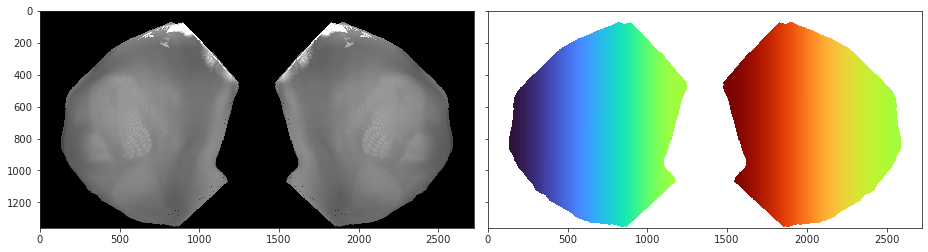

In [5]:
fig, axes = create_figure(1, 2, (13, 6), True, True)
axes[0].imshow(x, cmap='Greys_r')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, al.lookup), cmap='turbo')

<matplotlib.image.AxesImage object at 0x7fad7c97bb80>

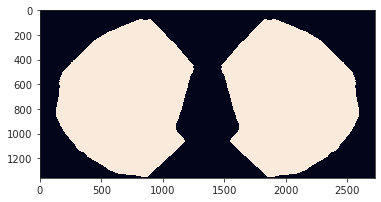

In [6]:
plt.imshow(al.lookup > 0)

In [19]:
from register.parcellation import kmeans_parcellation

In [9]:
(al.lookup > 0).sum()

2029519

In [25]:
from register.atlas import mask_left_right
lr = mask_left_right(al.lookup > 0, 1)

In [27]:
# %%time
parc = kmeans_parcellation(al.lookup > 0, 64, 4, lr_axis=1)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


2029518 1014760 1014759

In [29]:
save_obj(parc, 'parc_n64', tmp_dir, 'npy')

[PROGRESS] 'parc_n64.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/parc_n64.npy'

In [8]:
# parc = np.load('/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/parc_n128.npy', allow_pickle=True).item()
# list(parc)

['parcel', 'eroded', 'cluster_centers', 'mask_l', 'mask_r', 'radius']

<matplotlib.image.AxesImage object at 0x7fad6fabfeb0>

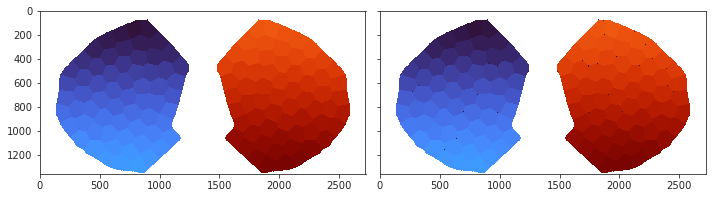

In [30]:
fig, axes = create_figure(1, 2, (10, 4), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, parc['eroded'].squeeze()), cmap='turbo')

In [31]:
from skimage.feature import canny

In [32]:
contour = parc['parcel'].squeeze().astype(float)
contour = canny(contour, sigma=1e-10)

[(100.0, 700.0), (500.0, 800.0)]

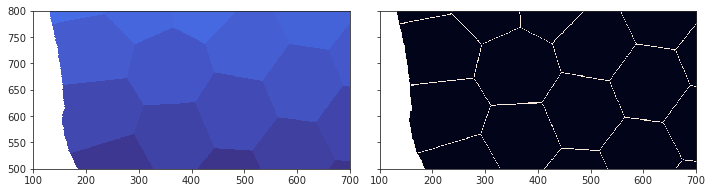

In [33]:
fig, axes = create_figure(1, 2, (10, 4), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(al.lookup == 0, contour))

axes[1].set(xlim=(100, 700), ylim=(500, 800))

<matplotlib.image.AxesImage object at 0x7fad7073b370>

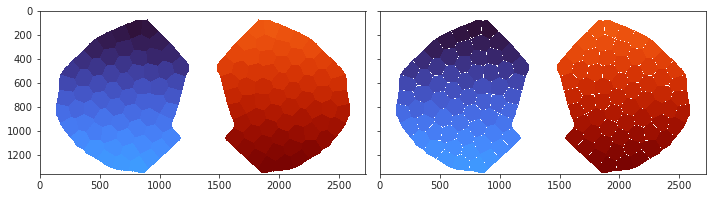

In [34]:
fig, axes = create_figure(1, 2, (10, 4), True, True)
axes[0].imshow(np.ma.masked_where(al.lookup == 0, parc['parcel'].squeeze()), cmap='turbo')
axes[1].imshow(np.ma.masked_where(np.logical_or(al.lookup == 0, contour), parc['parcel'].squeeze()), cmap='turbo')

In [35]:
al.id_l, al.id_r

(1, 2)

In [46]:
np.unique(parc['parcel'][parc['parcel'].nonzero()])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320],
      dtype=uint32)

In [49]:
np.mod(np.unique(parc['parcel'][parc['parcel'].nonzero()]), 256)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=uint32)

In [53]:
parcel3d = np.zeros(al.template.shape, dtype='uint32')
parcel3d.shape

(1320, 800, 1140)

In [60]:
for ii in tqdm(np.unique(parc['parcel'][parc['parcel'].nonzero()])):
    idxs = np.where(parc['parcel'] == ii)
    for i in al.lookup[idxs]:
        path = al.paths[i]
        path = path[path.nonzero()]
        for jj, layer in enumerate(np.array_split(path, 4)):
            parcel3d.flat[layer] = ii + jj * 64

  0%|          | 0/128 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7fa71b1ad8b0>

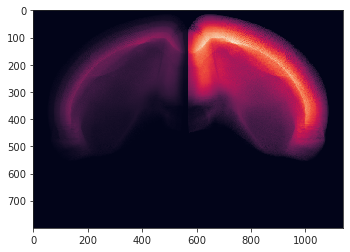

In [61]:
plt.imshow(parcel3d.mean(0))

In [62]:
np.unique(parcel3d[parcel3d.nonzero()])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512], dtype=uint32)

In [63]:
len(np.unique(parcel3d[parcel3d.nonzero()])), 64 * 4 * 2

(512, 512)

<matplotlib.image.AxesImage object at 0x7fa6fc33f6d0>

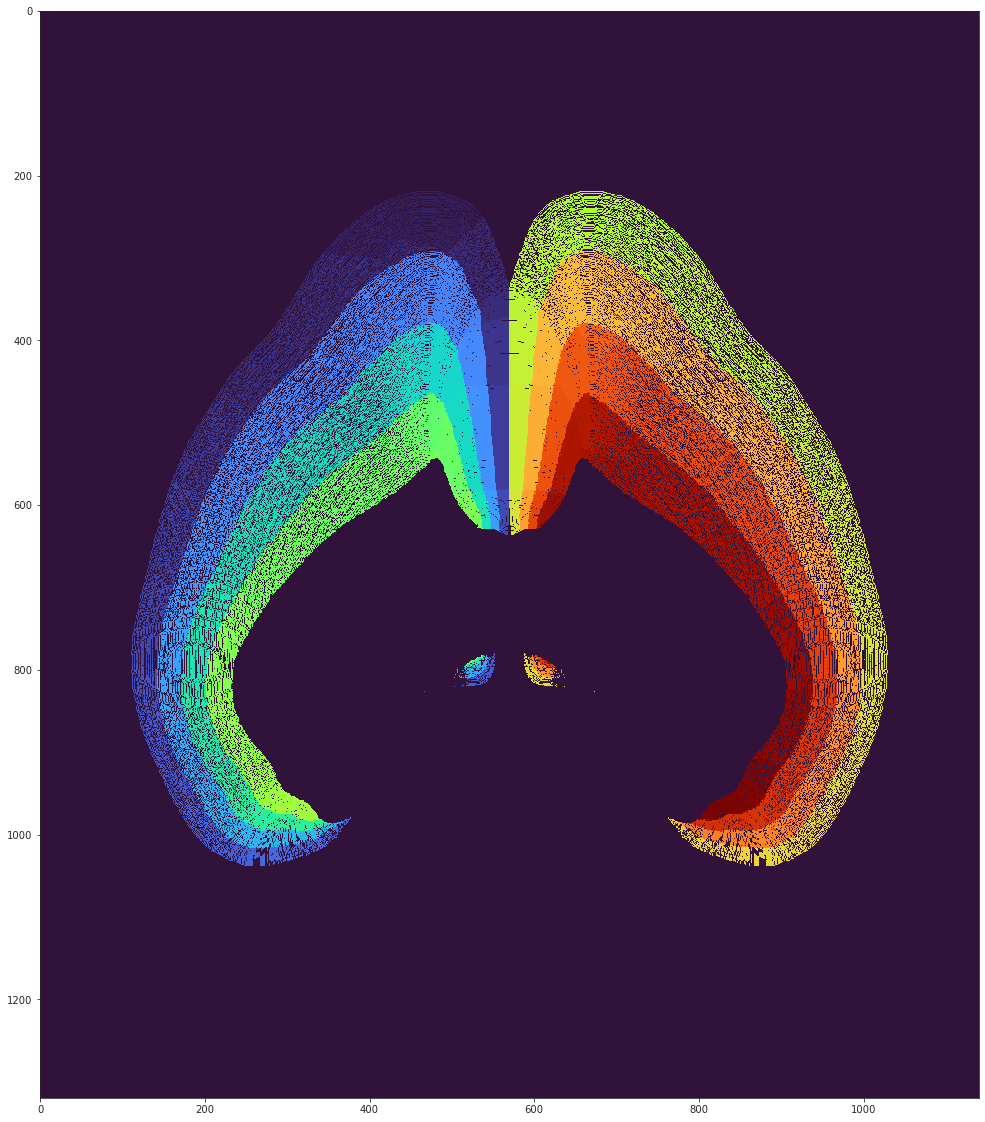

In [65]:
plt.figure(figsize=(30, 20))
plt.imshow(parcel3d[:, 200, :], cmap='turbo')

In [67]:
from scipy import ndimage as scipy_img

def fill(data, invalid=None):
    ind = scipy_img.distance_transform_edt(
        input=invalid if invalid is
        not None else np.isnan(data),
        return_distances=False,
        return_indices=True,
    )
    return data[tuple(ind)]

In [68]:
valid = np.logical_and(parcel3d > 0, al.iso_mask)
invalid = np.logical_and(parcel3d == 0, al.iso_mask)

<matplotlib.image.AxesImage object at 0x7fa6fc308a90>

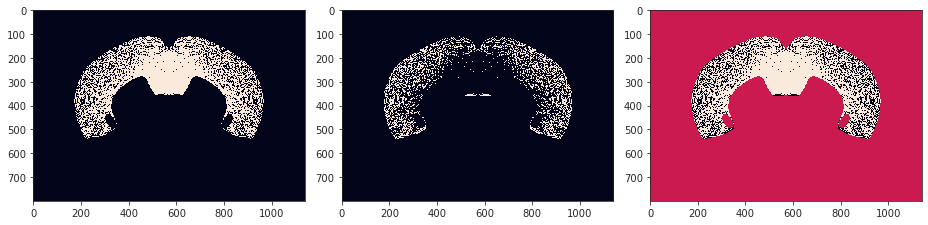

In [69]:
fig, axes = create_figure(1, 3, (13, 10))
axes[0].imshow(valid[400])
axes[1].imshow(invalid[400])
axes[2].imshow(valid[400].astype(float) - invalid[400].astype(float))

In [70]:
valid.sum(), invalid.sum()

(84843848, 38438776)

In [72]:
84843848 / (38438776 + 84843848), 38438776 / (38438776 + 84843848)

(0.6882060524604019, 0.3117939475395981)

In [73]:
%%time
parcel3d_fill = fill(parcel3d, invalid)

CPU times: user 6min 37s, sys: 46.3 s, total: 7min 23s
Wall time: 7min 23s


<matplotlib.image.AxesImage object at 0x7fa7620a48e0>

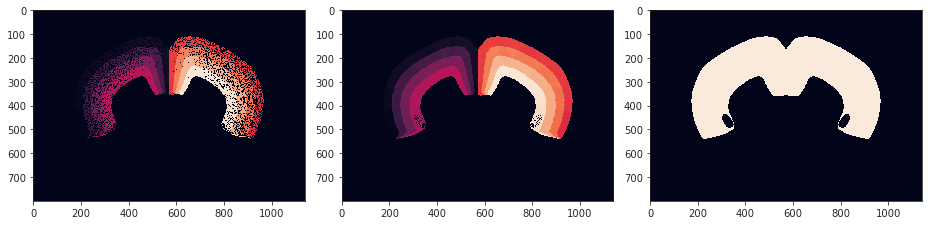

In [74]:
fig, axes = create_figure(1, 3, (13, 10))
axes[0].imshow(parcel3d[400])
axes[1].imshow(parcel3d_fill[400])
axes[2].imshow(al.iso_mask[400])

In [75]:
parcel3d_fill_fx = parcel3d_fill.copy()
parcel3d_fill_fx[~al.iso_mask] = 0
parcel3d_fill_fx.dtype

dtype('uint32')

In [76]:
len(np.unique(parcel3d_fill_fx[parcel3d_fill_fx.nonzero()]))

512

<matplotlib.image.AxesImage object at 0x7fa758fa0d60>

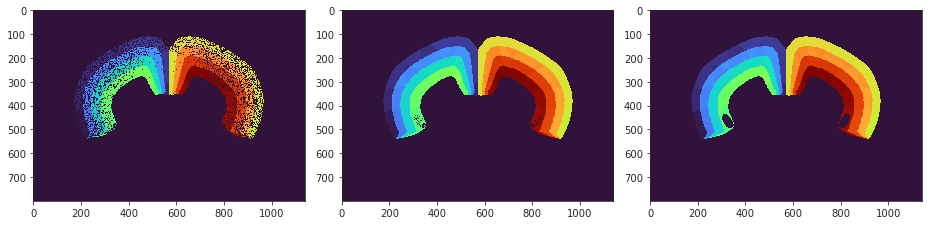

In [79]:
fig, axes = create_figure(1, 3, (13, 10))
axes[0].imshow(parcel3d[400], cmap='turbo')
axes[1].imshow(parcel3d_fill[400], cmap='turbo')
axes[2].imshow(parcel3d_fill_fx[400], cmap='turbo')

In [80]:
(parcel3d_fill == 255).sum(), (parcel3d_fill == 256).sum()

(30273, 29827)

In [81]:
(parcel3d_fill_fx == 255).sum(), (parcel3d_fill_fx == 256).sum()

(30273, 29827)

<matplotlib.image.AxesImage object at 0x7fa8351bb940>

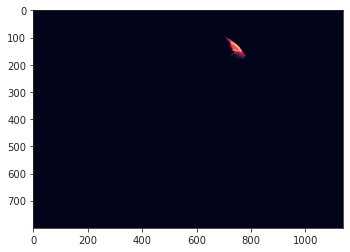

In [84]:
plt.imshow((parcel3d_fill_fx == 256 + 4 * 64).mean(0))

In [328]:
"""parcel3d_full = np.zeros_like(al.template).astype('uint32')
parcel3d_full[al.slice_l] = parcel3d_l_fill_fx
parcel3d_full += np.flip(parcel3d_full, axis=2)
parcel3d_full[np.logical_and(al.mask_r, al.iso_mask)] += 256
parcel3d_full *= al.iso_mask"""

<matplotlib.image.AxesImage object at 0x7f9bcd74d2e0>

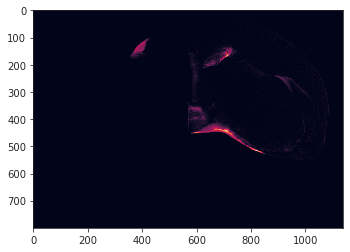

In [351]:
"""plt.imshow((parcel3d_full == 256).mean(0))"""

<matplotlib.image.AxesImage object at 0x7f9c647baa30>

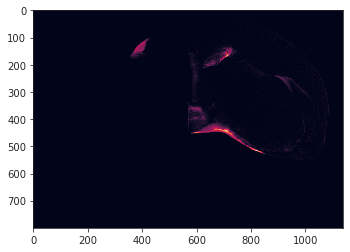

In [321]:
plt.imshow((parcel3d_full == 256).mean(0))

In [76]:
"""%%time

parcel3d_full = np.zeros_like(al.template).astype('uint32')
parcel3d_full[al.slice_l] = parcel3d_l_fill

parcel3d_full += np.flip(parcel3d_full, axis=2)
parcel3d_full[al.slice_r] += 256
parcel3d_full *= al.iso_mask"""

CPU times: user 10.4 s, sys: 3.44 s, total: 13.8 s
Wall time: 13.8 s


<matplotlib.image.AxesImage object at 0x7fa834d9c1f0>

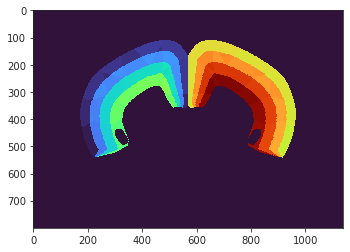

In [85]:
plt.imshow(parcel3d_fill_fx[400], cmap='turbo')

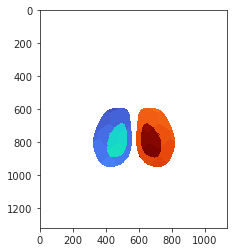

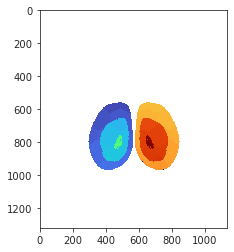

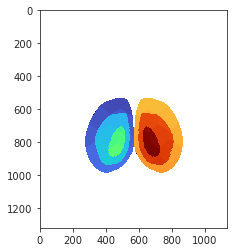

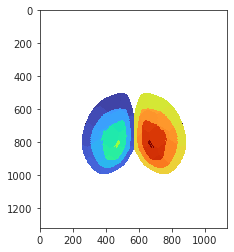

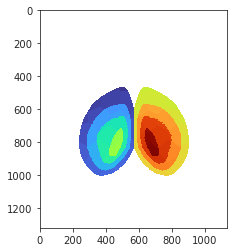

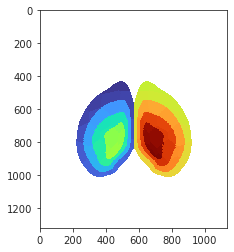

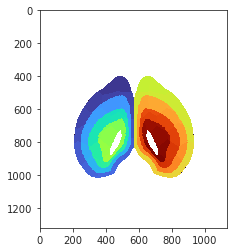

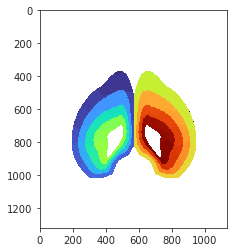

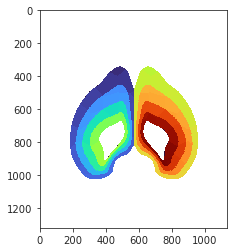

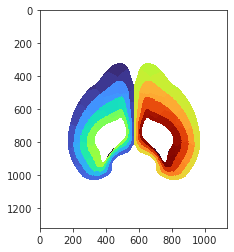

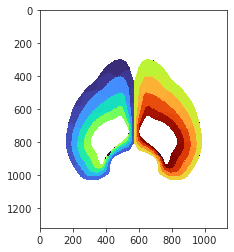

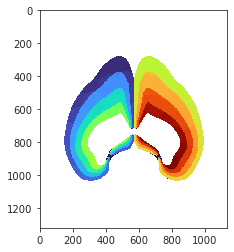

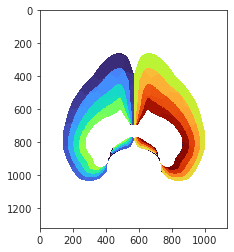

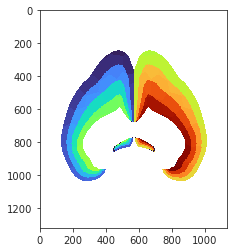

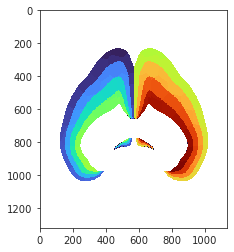

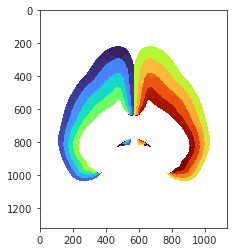

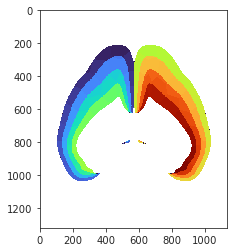

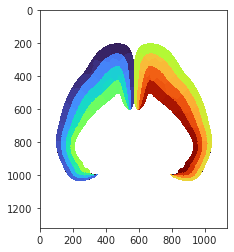

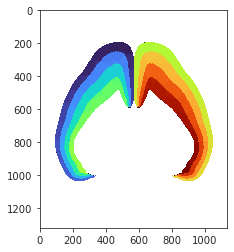

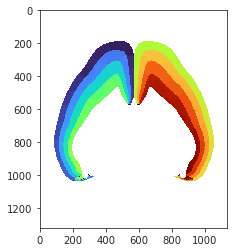

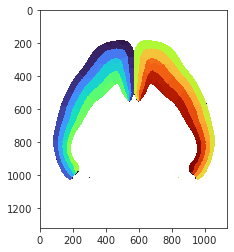

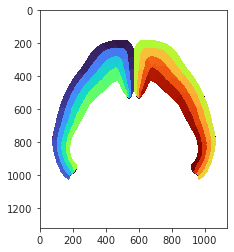

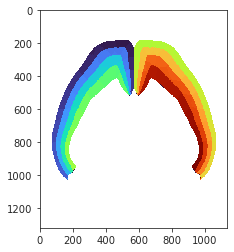

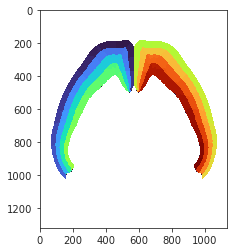

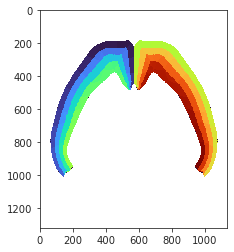

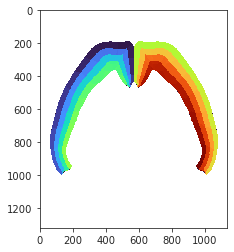

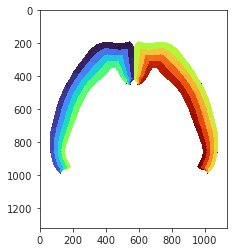

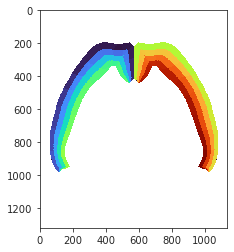

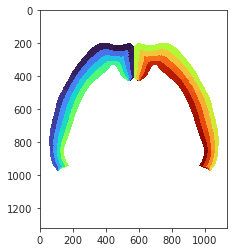

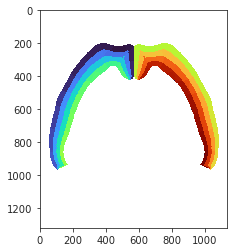

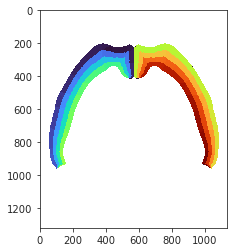

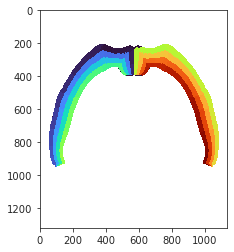

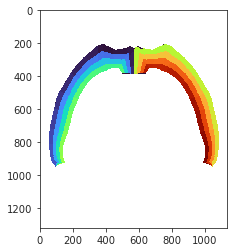

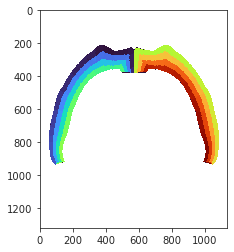

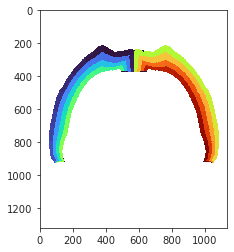

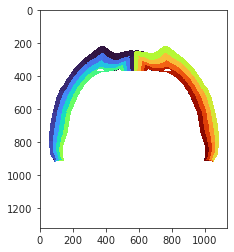

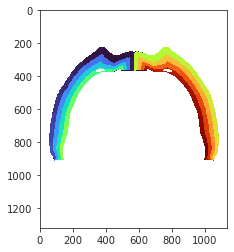

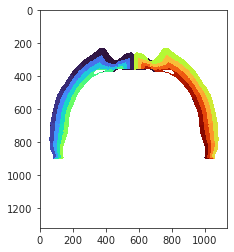

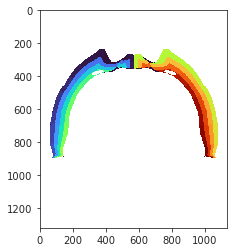

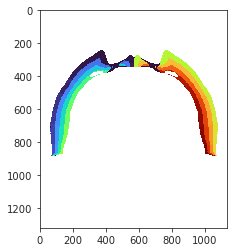

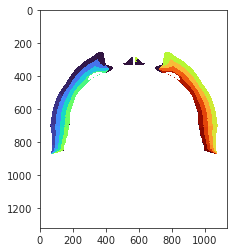

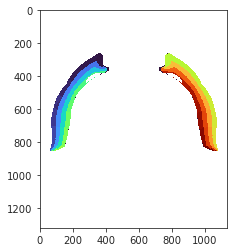

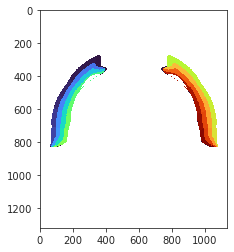

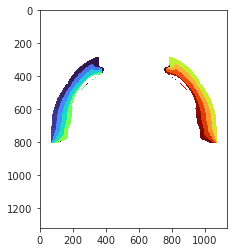

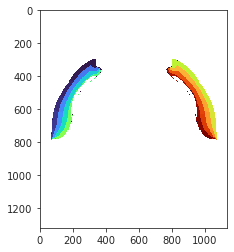

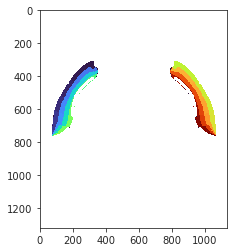

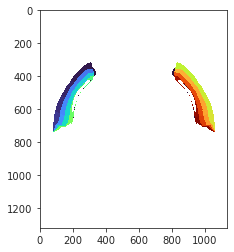

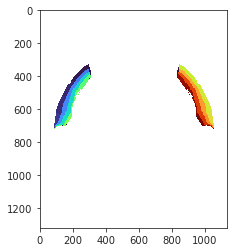

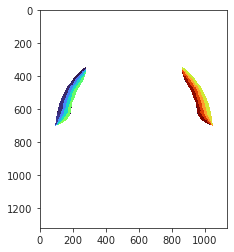

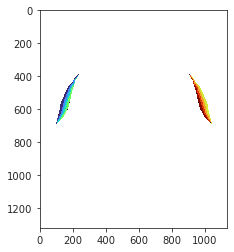

In [86]:
for i in range(50):
    plt.imshow(np.ma.masked_where(~al.iso_mask[:, 50 + i * 10, :], parcel3d_fill_fx[:, 50 + i * 10, :]), cmap='turbo')
    plt.show()

In [87]:
save_obj(parcel3d_fill_fx, 'parcel3d_fill_fx', tmp_dir, 'npy')

[PROGRESS] 'parcel3d_fill_fx.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/parcel3d_fill_fx.npy'

## Ants resize

In [90]:
mask = np.isin(parcel3d_fill_fx, [20, 20 + 64, 20 + 128, 20 + 64 * 3])
x = parcel3d_fill_fx.copy()
x[~mask] = 0

<matplotlib.colorbar.Colorbar object at 0x7fa82fbe7190>

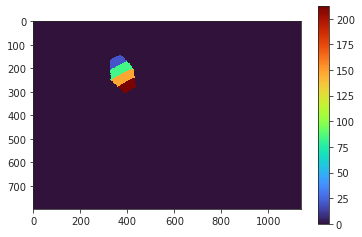

In [91]:
plt.imshow(x[400], cmap='turbo')
plt.colorbar()

In [92]:
mask = np.isin(parcel3d_fill_fx, [20 + 256, 20 + 256 + 64, 20 + 256 + 128, 20 + 256 + 64 * 3])
x = parcel3d_fill_fx.copy()
x[~mask] = 0

<matplotlib.colorbar.Colorbar object at 0x7fa82f9e8b80>

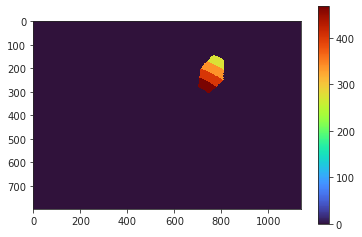

In [93]:
plt.imshow(x[400], cmap='turbo')
plt.colorbar()

<matplotlib.image.AxesImage object at 0x7fa82f976310>

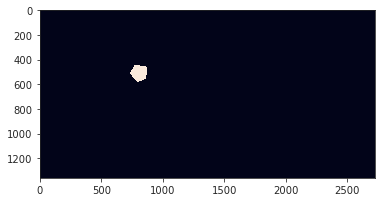

In [94]:
plt.imshow(parc['parcel'] == 20)

## Render

In [2]:
%%time
parcel3d_fill_fx = np.load('/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/parcel3d_fill_fx.npy')
parcel3d_fill_fx.dtype

CPU times: user 2.71 ms, sys: 2.49 s, total: 2.49 s
Wall time: 2.49 s


dtype('uint32')

In [3]:
from register.register import reset_ants_img, ants

In [4]:
%%time
parcel3d_fill_fx = reset_ants_img(parcel3d_fill_fx, spacing=10)
parcel3d_fill_fx

CPU times: user 14.9 s, sys: 3.83 s, total: 18.7 s
Wall time: 18.7 s


ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (1320, 800, 1140)
         Spacing    : (10.0, 10.0, 10.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [5]:
%%time
al25 = Allen(25, full_load=True)

CPU times: user 4 s, sys: 2.7 s, total: 6.7 s
Wall time: 8 s


In [6]:
%%time
parcel3d = ants.resample_image_to_target(
    image=parcel3d_fill_fx,
    target=reset_ants_img(al25.template, spacing=25),
    interp_type='genericLabel',
)
parcel3d

CPU times: user 26min 24s, sys: 30.5 s, total: 26min 55s
Wall time: 1min 30s


ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (528, 320, 456)
         Spacing    : (25.0, 25.0, 25.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [7]:
parcel3d = parcel3d.numpy()

<matplotlib.image.AxesImage object at 0x7f4188587160>

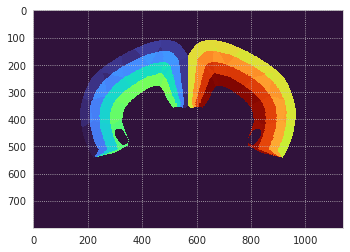

In [8]:
plt.imshow(parcel3d_fill_fx[400], cmap='turbo')

<matplotlib.image.AxesImage object at 0x7f41773a4a90>

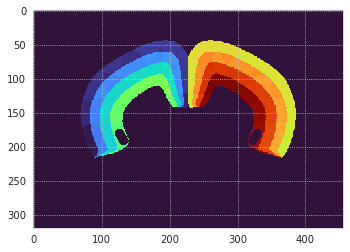

In [9]:
plt.imshow(parcel3d[int(400 / 2.5)], cmap='turbo')

In [10]:
regions = np.unique(parcel3d[parcel3d.nonzero()])
len(regions)

512

In [15]:
len(regions)

512

In [69]:
alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n64*4'
save_dir = tmp_dir


if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions), total=len(regions)):
    x = parcel3d == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/512 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n64*4_k512.html

In [16]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_25um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [17]:
alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = 'columnar_n64*4_lite'
save_dir = tmp_dir


if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for j in tqdm([i for i in range(1, 64) if i % 5 == 0]):
    col = [j + ll * 64 for ll in range(4)]
    selected = col + [e + 64 * 4 for e in col]
    print(j, selected)
    for region_id in selected:
        x = parcel3d == region_id
        x = src_space.map_stack_to(scene.atlas.space, x)
        c = cmap((region_id - 1) / len(regions))[:3]
        colors.append(c)

        vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
        surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
        surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
        surfaces.append(surf)
        names.append(f"region_{region_id}")

scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"5cols",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/12 [00:00<?, ?it/s]

5
[5, 69, 133, 197, 261, 325, 389, 453]

10
[10, 74, 138, 202, 266, 330, 394, 458]

15
[15, 79, 143, 207, 271, 335, 399, 463]

20
[20, 84, 148, 212, 276, 340, 404, 468]

25
[25, 89, 153, 217, 281, 345, 409, 473]

30
[30, 94, 158, 222, 286, 350, 414, 478]

35
[35, 99, 163, 227, 291, 355, 419, 483]

40
[40, 104, 168, 232, 296, 360, 424, 488]

45
[45, 109, 173, 237, 301, 365, 429, 493]

50
[50, 114, 178, 242, 306, 370, 434, 498]

55
[55, 119, 183, 247, 311, 375, 439, 503]

60
[60, 124, 188, 252, 316, 380, 444, 508]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n64*4_lite_5cols.html

In [82]:
vox = [(parcel3d == i).sum()  for i in regions]

<AxesSubplot:ylabel='Count'>

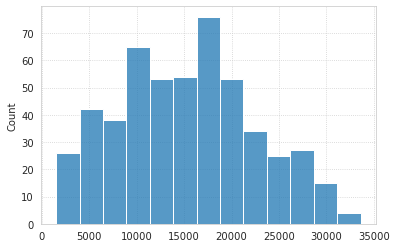

In [83]:
sns.histplot(vox)

## Voronoi

In [133]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
rng = np.random.default_rng()
points = rng.random((10, 2)) * 100
com = np.array([points[:, 0].mean(), points[:, 1].mean()])

In [134]:
tri = Delaunay(points)

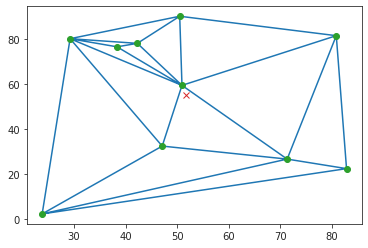

In [135]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(com[0], com[1], 'x')
plt.show()

In [136]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

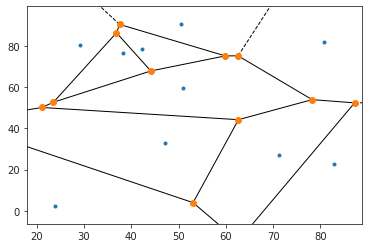

In [137]:
fig = voronoi_plot_2d(vor)
plt.show()

In [146]:
points = [i[[0, -1]].reshape(-1, 2) for i in parc['cluster_centers'].values()]
points = np.concatenate(points)
points.shape

(128, 2)

[<matplotlib.lines.Line2D object at 0x7f9c64a67c10>]

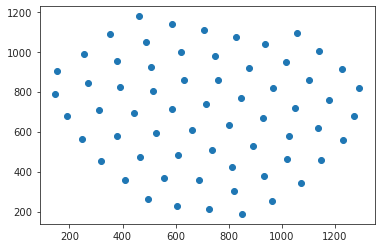

In [150]:
plt.plot(points[:64,0], points[:64,1], 'o')

In [147]:
vor = Voronoi(points[:64])

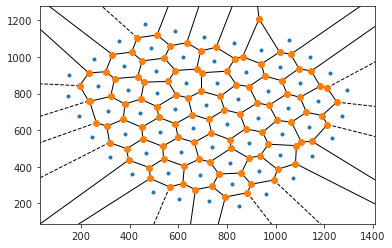

In [148]:
fig = voronoi_plot_2d(vor)
plt.show()

<matplotlib.image.AxesImage object at 0x7f9c63e67550>

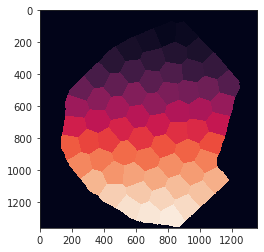

In [151]:
plt.imshow(parcel2d)

<matplotlib.image.AxesImage object at 0x7f9c64aa1b50>

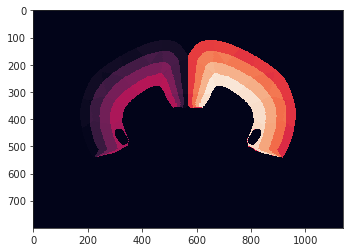

In [152]:
plt.imshow(parcel3d_full[400])

In [156]:
from skimage.measure import block_reduce
parcel3d_down = block_reduce(parcel3d_full, (10, 10, 10), func=np.max)

<matplotlib.image.AxesImage object at 0x7f9c64600c70>

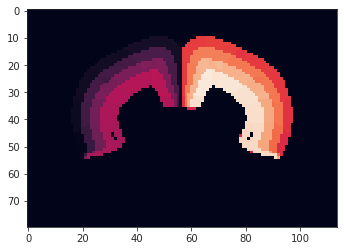

In [157]:
plt.imshow(parcel3d_down[40])

In [384]:
sys.path.insert(0, pjoin(git_dir, 'brainrender'))
sys.path.insert(0, pjoin(git_dir, 'vedo'))

In [385]:
from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume

In [386]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

In [387]:
scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [388]:
cmap = sns.color_palette('turbo', as_cmap=True)

In [389]:
masks = {i: parcel3d_down == i for i in np.unique(parcel3d_down) if i > 0}
len(set(masks))

512

In [390]:
alpha = 1.0

masks = {i: parcel3d_down == i for i in np.unique(parcel3d_down) if i > 0}
len(set(masks))

save_name = 'columnar_n64'
save_dir = tmp_dir

In [391]:
alpha = 1.0

masks = {i: parcel3d_down == i for i in np.unique(parcel3d_down) if i > 0}
len(set(masks))

save_name = 'columnar_n64'
save_dir = tmp_dir


base_name = 'Isocortex'
if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for i, (region_id, x) in enumerate(masks.items()):
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(masks))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
    
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(masks)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
# br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/columnar_n64_k512.html

In [277]:
x = parcel3d_down // 64
x += 1
masks = {i: np.logical_and(x == i, parcel3d_down > 0) for i in range(1, 8 + 1)}

<matplotlib.image.AxesImage object at 0x7f9bce5450d0>

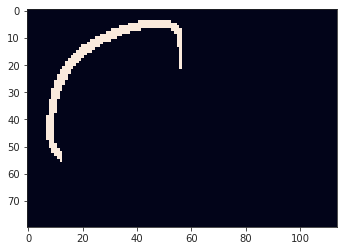

In [278]:
plt.imshow(masks[1][60])

In [279]:
cmap = sns.color_palette('turbo', as_cmap=True)

In [280]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

alpha = 1.0

save_name = 'layers_n64'
save_dir = tmp_dir


surfaces, names, colors = [], [], []
for i, (region_id, x) in enumerate(masks.items()):
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(masks))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(masks)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
# br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/layers_n64_k8.html

In [281]:
np.unique(parcel3d_down[parcel3d_down.nonzero()])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512], dtype=uint32)

In [282]:
np.unique(parcel3d_full[parcel3d_full.nonzero()])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512], dtype=uint32)

In [284]:
x = parcel3d_full[al.slice_l]
unq_l = np.unique(x[x.nonzero()])
len(unq_l)

256

In [285]:
x = parcel3d_full[al.slice_r]
np.unique(x[x.nonzero()])
unq_r = np.unique(x[x.nonzero()])
len(unq_r)

257

In [287]:
unq_l

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256], dtype=uint32)

In [286]:
unq_r

array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502,
       503, 504, 505, 506, 507, 508, 509, 510, 511, 512], dtype=uint32)

In [288]:
mask = parcel3d_full == 256

In [298]:
mask = parcel3d_down == 256

<matplotlib.image.AxesImage object at 0x7f9bcde46160>

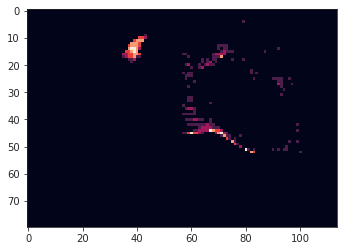

In [302]:
plt.imshow(mask.mean(0))

In [355]:
masks = {1: parcel3d_down == 256}

In [356]:
alpha = 1.0

save_name = 'test'
save_dir = tmp_dir

In [357]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

alpha = 1.0

save_name = 'layers_n64'
save_dir = tmp_dir


surfaces, names, colors = [], [], []
for i, (region_id, x) in enumerate(masks.items()):
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(masks))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(masks)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
# br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/layers_n64_k1.html

In [363]:
a = np.logical_and(parcel3d_full == 0, al.iso_mask)

In [364]:
a.sum()

248702

<matplotlib.image.AxesImage object at 0x7f9bcd425580>

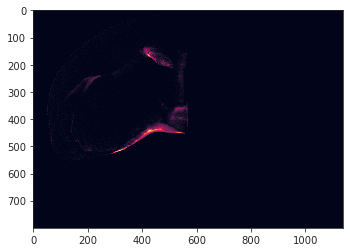

In [365]:
plt.imshow(a.mean(0))

In [366]:
from skimage.measure import block_reduce
a_down = block_reduce(a, (10, 10, 10), func=np.mean)

<matplotlib.image.AxesImage object at 0x7f9bcc248d60>

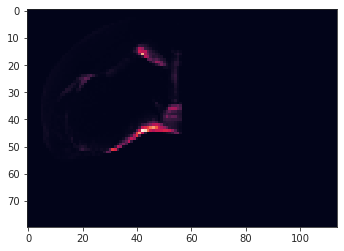

In [367]:
plt.imshow(a_down.mean(0))

In [392]:
masks = {1: a > 0}

In [393]:
alpha = 1.0

save_name = 'test'
save_dir = tmp_dir

In [394]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_10um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

surfaces, names, colors = [], [], []
for i, (region_id, x) in enumerate(masks.items()):
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(masks))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(masks)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
# br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/test_k1.html

In [395]:
scene.atlas.zoom

2.5

In [396]:
scene.atlas.resolution

(10.0, 10.0, 10.0)